<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# 大模型推理 PD 分离

PD 分离（Prefill-Decode Separation）是大模型推理优化中的重要技术，它能有效解决计算密集型 Prefill 阶段和内存密集型 Decode 阶段资源竞争的问题。

PD 分离的核心思想是将大模型推理的计算密集型 Prefill 阶段和内存密集型 Decode 阶段分离到不同的硬件资源上。下面我们用一个简化的 Transformer 模型来模拟 PD 分离，并进行性能对比。

## 1. 环境准备

首先，我们导入必要的库并设置实验环境：

In [ ]:
#指定GPU ID
CUDA_VISIBLE_DEVICES=0
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

# 设置随机种子确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 使用 GPU 如果可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


## 2. Transformer 模型

大语言模型的核心是 Transformer 解码器。让我们先实现一个简化版的 Transformer 层，下面是简化的 Transformer 层实现：

In [2]:
class SimplifiedTransformerLayer(nn.Module):
    
    def __init__(self, hidden_size: int, num_heads: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads  # 每个注意力头的维度
        
        self.self_attn = nn.MultiheadAttention(
            embed_dim=hidden_size, 
            num_heads=num_heads,
            batch_first=True  # 使输入形状为(batch_size, seq_len, hidden_size)
        )
        
        # 前馈网络 - 每个 token 独立进行的线性变换和非线性激活
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),  # 扩展维度
            nn.ReLU(),  # 非线性激活
            nn.Linear(hidden_size * 4, hidden_size)   # 还原维度
        )
        
        # 层归一化 - 稳定训练和推理过程
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
    
    def forward(self, x: torch.Tensor, 
               kv_cache: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
              ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # 自注意力子层，支持 KV 缓存
        # 在推理时，我们可以缓存 Key 和 Value 以避免重复计算
        attn_output, _ = self.self_attn(
            query=x, 
            key=x if kv_cache is None else kv_cache[0],
            value=x if kv_cache is None else kv_cache[1],
            need_weights=False  # 不需要注意力权重，节省计算
        )
        
        # 残差连接 + 层归一化
        x = self.norm1(x + attn_output)
        
        # 前馈网络子层
        ffn_output = self.ffn(x)
        
        # 残差连接 + 层归一化
        x = self.norm2(x + ffn_output)
        
        # 返回输出和新的 KV 缓存（这里简化处理，实际中应缓存 key 和 value）
        return x, (x, x)

一个完整的语言模型通常由以下几个部分组成：
1. 词嵌入层（将 token 转换为向量）
2. 多个 Transformer 层（特征提取和上下文理解）
3. 输出投影层（将模型输出转换为词汇表上的概率分布）

In [3]:
class SimpleLanguageModel(nn.Module):
    
    def __init__(self, vocab_size: int, hidden_size: int, num_layers: int, num_heads: int):
        super().__init__()
        # 词嵌入层：将 token ID 转换为向量表示
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        # 多个 Transformer 层
        self.layers = nn.ModuleList([
            SimplifiedTransformerLayer(hidden_size, num_heads) 
            for _ in range(num_layers)
        ])
        
        # 输出投影层：将模型输出转换为词汇表大小的向量
        self.output_proj = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input_ids: torch.Tensor, 
               kv_caches: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None
              ) -> Tuple[torch.Tensor, List[Tuple[torch.Tensor, torch.Tensor]]]:
        # 将 token ID 转换为向量
        x = self.embedding(input_ids)
        
        # 如果没有提供 KV 缓存，则初始化
        if kv_caches is None:
            kv_caches = [None] * len(self.layers)
        
        new_kv_caches = []
        # 逐层处理
        for i, layer in enumerate(self.layers):
            x, new_kv_cache = layer(x, kv_caches[i])
            new_kv_caches.append(new_kv_cache)
        
        # 转换为词汇表上的概率分布
        logits = self.output_proj(x)
        return logits, new_kv_caches

## 3. 传统合并部署方式

在传统部署方式中，Prefill 和 Decode 阶段在同一设备上执行，共享硬件资源。让我们实现这种方式并理解其工作流程：

In [4]:
class TraditionalDeployment:

    def __init__(self, model: nn.Module):
        # 将模型移动到指定设备
        self.model = model.to(device)
        # 设置为评估模式（关闭 dropout 等训练时的特性）
        self.model.eval()
    
    def process_request(self, prompt: List[int], output_length: int) -> Tuple[List[int], float, float, float]:
        # 将提示词转换为张量并移动到设备
        prompt_tensor = torch.tensor([prompt], device=device)
        
        # --------------------------
        # Prefill 阶段：处理整个提示词
        # --------------------------
        start_prefill = time.time()
        # 禁用梯度计算以加速推理
        with torch.no_grad():
            # 处理整个提示词，获取初始 logits 和 KV 缓存
            logits, kv_caches = self.model(prompt_tensor)
        prefill_time = time.time() - start_prefill
        
        # --------------------------
        # Decode 阶段：自回归生成 token
        # --------------------------
        start_decode = time.time()
        generated_tokens = []
        # 从 Prefill 的结果中获取第一个要生成的 token
        current_token = torch.argmax(logits[:, -1, :], dim=-1)
        
        with torch.no_grad():
            # 循环生成指定数量的 token
            for _ in range(output_length):
                # 使用当前 token 和之前的 KV 缓存进行推理
                logits, kv_caches = self.model(current_token.unsqueeze(1), kv_caches)
                # 选择概率最高的 token（贪心解码）
                next_token = torch.argmax(logits[:, -1, :], dim=-1)
                generated_tokens.append(next_token.item())
                # 更新当前 token，准备下一轮生成
                current_token = next_token
        
        decode_time = time.time() - start_decode
        total_time = prefill_time + decode_time
        return generated_tokens, total_time, prefill_time, decode_time

## 4. PD 分离部署方式

现在，让我们实现 PD 分离部署方式。在这种方式中，我们将 Prefill 和 Decode 阶段分离到不同的"逻辑设备"上（在实际应用中会是物理上分离的硬件）。

In [5]:
class PDDisaggregationDeployment:
    
    def __init__(self, model: nn.Module):
        # 在实际应用中，这两个模型会部署在不同的物理设备上
        # 这里我们用两个模型实例来模拟
        self.prefill_model = model.to(device)  # Prefill 专用模型
        self.decode_model = model.to(device)   # Decode 专用模型
        
        # 设置为评估模式
        self.prefill_model.eval()
        self.decode_model.eval()
    
    def process_request(self, prompt: List[int], output_length: int) -> Tuple[List[int], float, float, float, float]:
        prompt_tensor = torch.tensor([prompt], device=device)
        
        # --------------------------
        # Prefill 阶段：在专用设备上处理
        # --------------------------
        start_prefill = time.time()
        with torch.no_grad():
            logits, kv_caches = self.prefill_model(prompt_tensor)
        prefill_time = time.time() - start_prefill
        
        # --------------------------
        # KV 缓存传输：模拟跨设备传输
        # --------------------------
        start_transfer = time.time()
        # 在实际应用中，这里会涉及网络传输或 PCIe 传输
        # 我们通过克隆张量来模拟传输开销
        transferred_kv = [(k.clone(), v.clone()) for k, v in kv_caches]
        transfer_time = time.time() - start_transfer
        
        # --------------------------
        # Decode 阶段：在专用设备上处理
        # --------------------------
        start_decode = time.time()
        generated_tokens = []
        current_token = torch.argmax(logits[:, -1, :], dim=-1)
        
        with torch.no_grad():
            for _ in range(output_length):
                logits, transferred_kv = self.decode_model(current_token.unsqueeze(1), transferred_kv)
                next_token = torch.argmax(logits[:, -1, :], dim=-1)
                generated_tokens.append(next_token.item())
                current_token = next_token
        
        decode_time = time.time() - start_decode
        total_time = prefill_time + transfer_time + decode_time
        return generated_tokens, total_time, prefill_time, decode_time, transfer_time

## 5. 实验设计与执行

为了比较两种部署方式的性能，我们需要生成模拟的工作负载并运行实验。

工作负载由一系列请求组成，每个请求包含：

- 一个随机生成的提示词（模拟用户输入）
- 期望的输出长度（模拟用户希望生成的文本长度）

In [6]:
def generate_workload(num_requests: int) -> List[Tuple[List[int], int]]:
    workload = []
    for _ in range(num_requests):
        # 随机生成提示词长度（10-100 tokens）
        prompt_len = np.random.randint(10, 100)
        # 随机生成输出长度（5-50 tokens）
        output_len = np.random.randint(5, 50)
        # 随机生成提示词内容（token ID 范围：0-9999）
        prompt = np.random.randint(0, 10000, prompt_len).tolist()
        workload.append((prompt, output_len))
    return workload

运行对比实验

In [7]:
def run_experiment(model: nn.Module, workload: List[Tuple[List[int], int]]) -> Dict[str, List[float]]:
    """运行性能对比实验"""
    # 初始化两种部署方式
    traditional = TraditionalDeployment(model)
    pd_deploy = PDDisaggregationDeployment(model)
    
    # 存储实验结果
    results = {
        'traditional_total': [],  # 传统部署总时间
        'pd_total': [],           # PD 分离总时间
        'prefill_times': [],      # Prefill 阶段时间
        'decode_times': [],       # Decode 阶段时间
        'transfer_times': [],     # KV 缓存传输时间
        'prompt_lengths': [len(p) for p, _ in workload],  # 提示词长度
        'output_lengths': [l for _, l in workload]        # 输出长度
    }
    
    # 处理每个请求
    for i, (prompt, output_len) in enumerate(workload):
        print(f"处理请求 {i+1}/{len(workload)}")
        
        # 传统部署方式
        _, trad_total, prefill, decode = traditional.process_request(prompt, output_len)
        results['traditional_total'].append(trad_total)
        results['prefill_times'].append(prefill)
        results['decode_times'].append(decode)
        
        # PD 分离部署方式
        _, pd_total, _, _, transfer = pd_deploy.process_request(prompt, output_len)
        results['pd_total'].append(pd_total)
        results['transfer_times'].append(transfer)
    
    return results

model = SimpleLanguageModel(vocab_size=10000, hidden_size=512, num_layers=6, num_heads=8)

# 生成 20 个请求的工作负载
workload = generate_workload(20)

# 运行实验
print("开始实验...")
results = run_experiment(model, workload)

开始实验...
处理请求 1/20
处理请求 2/20
处理请求 3/20
处理请求 4/20
处理请求 5/20
处理请求 6/20
处理请求 7/20
处理请求 8/20
处理请求 9/20
处理请求 10/20
处理请求 11/20
处理请求 12/20
处理请求 13/20
处理请求 14/20
处理请求 15/20
处理请求 16/20
处理请求 17/20
处理请求 18/20
处理请求 19/20
处理请求 20/20


## 6. 实验结果分析

让我们计算并可视化实验结果，看看 PD 分离是否能带来性能提升。

In [8]:
# 计算平均性能指标
avg_trad_total = np.mean(results['traditional_total'])
avg_pd_total = np.mean(results['pd_total'])
avg_prefill = np.mean(results['prefill_times'])
avg_decode = np.mean(results['decode_times'])
avg_transfer = np.mean(results['transfer_times'])

# 计算性能提升百分比
performance_gain = ((avg_trad_total - avg_pd_total) / avg_trad_total) * 100 if avg_trad_total > 0 else 0

# 输出结果
print("\n" + "="*50)
print("实验结果汇总")
print("="*50)
print(f"传统部署平均总延迟: {avg_trad_total:.4f} 秒")
print(f"PD 分离部署平均总延迟: {avg_pd_total:.4f} 秒")
print(f"相对性能提升: {performance_gain:.2f}%")
print("-"*50)
print(f"平均 Prefill 时间: {avg_prefill:.4f} 秒")
print(f"平均 Decode 时间: {avg_decode:.4f} 秒")
print(f"平均 KV 传输时间: {avg_transfer:.4f} 秒")
print(f"传输开销占 PD 总时间比例: {(avg_transfer / avg_pd_total * 100):.2f}%")
print("="*50)


实验结果汇总
传统部署平均总延迟: 0.0703 秒
PD 分离部署平均总延迟: 0.0619 秒
相对性能提升: 11.98%
--------------------------------------------------
平均 Prefill 时间: 0.0071 秒
平均 Decode 时间: 0.0632 秒
平均 KV 传输时间: 0.0001 秒
传输开销占 PD 总时间比例: 0.12%


输出结果（4090）：

In [ ]:

==================================================
实验结果汇总
==================================================
传统部署平均总延迟: 0.0703 秒
PD 分离部署平均总延迟: 0.0619 秒
相对性能提升: 11.98%
--------------------------------------------------
平均 Prefill 时间: 0.0071 秒
平均 Decode 时间: 0.0632 秒
平均 KV 传输时间: 0.0001 秒
传输开销占 PD 总时间比例: 0.12%
==================================================

SyntaxError: invalid syntax (193452134.py, line 1)

结果可视化，让我们通过图表更直观地理解实验结果：

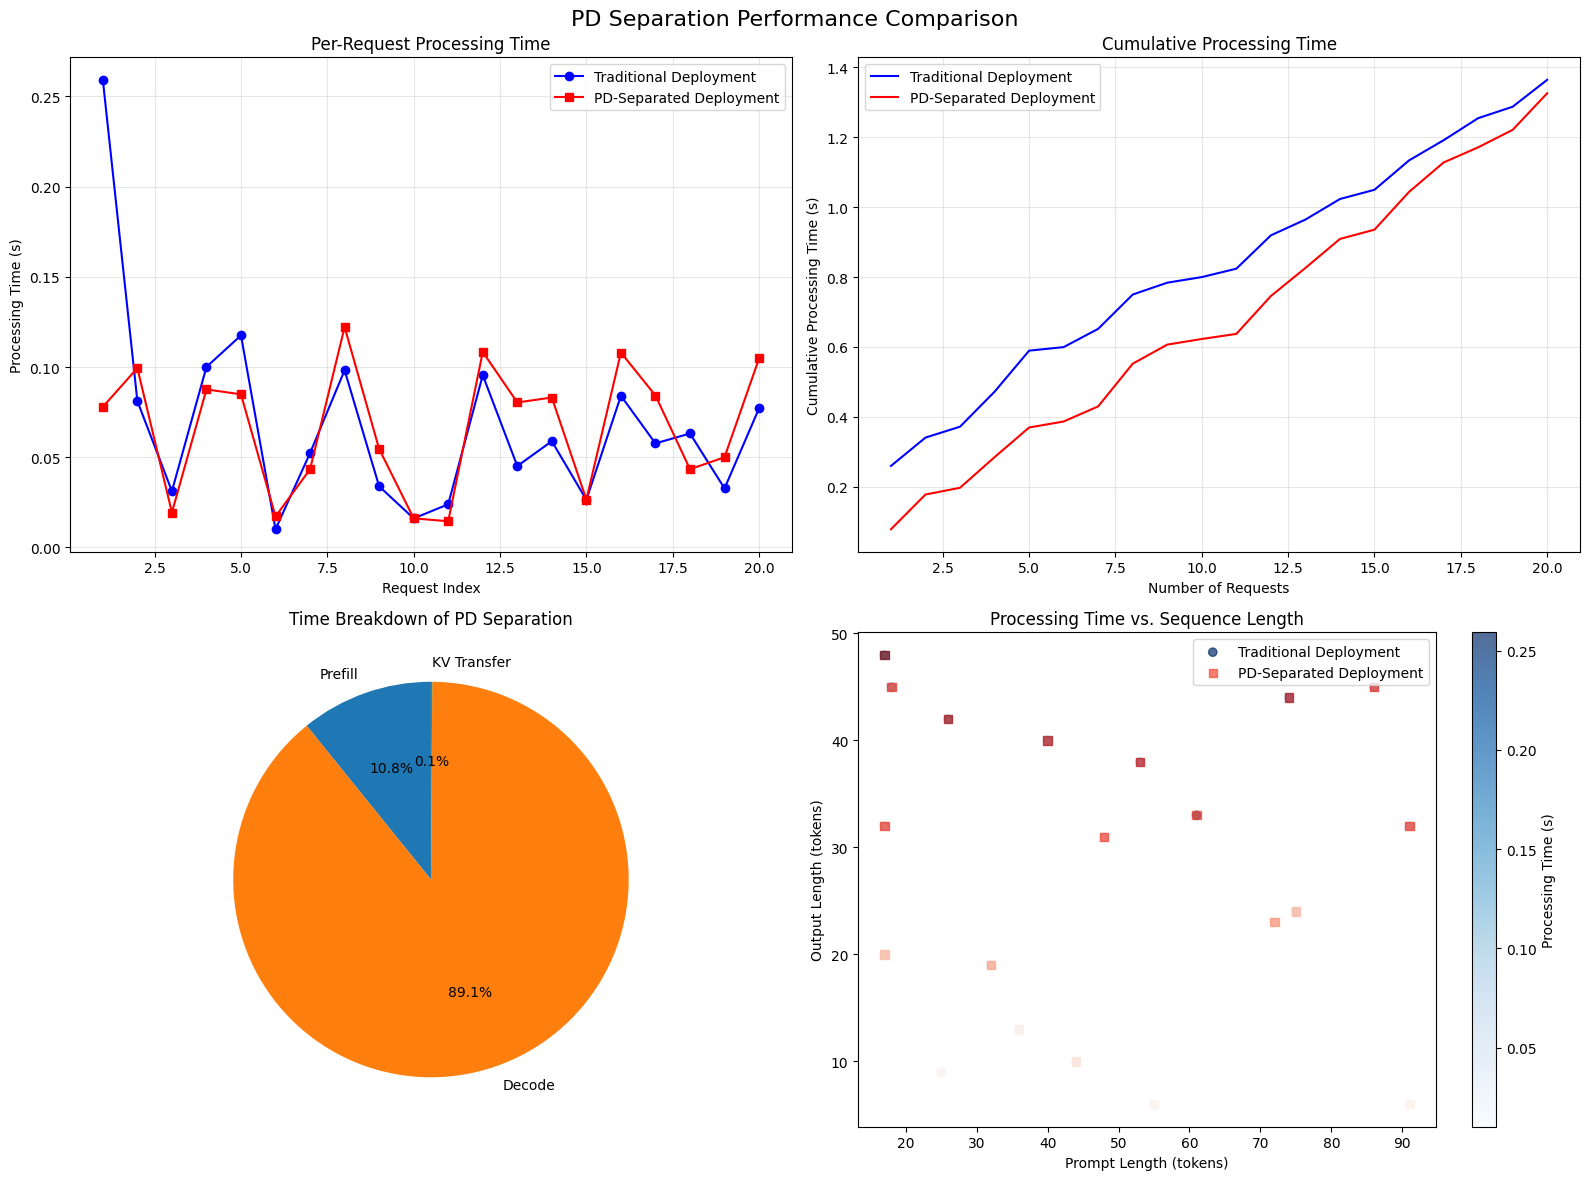

In [ ]:
def visualize_results(results: Dict[str, List[float]]):
    """可视化实验结果"""
    import numpy as np
    import matplotlib.pyplot as plt

    # 使用默认字体即可（英文不需要 CJK 字体）
    plt.rcParams['axes.unicode_minus'] = False

    # 创建 2x2 子图
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('PD Dispatch Performance Comparison', fontsize=16)

    # 1. 单个请求处理时间对比
    request_ids = range(1, len(results['traditional_total']) + 1)
    axes[0, 0].plot(
        request_ids,
        results['traditional_total'],
        'b-o',
        label='Traditional Deployment'
    )
    axes[0, 0].plot(
        request_ids,
        results['pd_total'],
        'r-s',
        label='PD-Dispatch Deployment'
    )
    axes[0, 0].set_xlabel('Request Index')
    axes[0, 0].set_ylabel('Processing Time (s)')
    axes[0, 0].set_title('Per-Request Processing Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 累积处理时间对比
    axes[0, 1].plot(
        request_ids,
        np.cumsum(results['traditional_total']),
        'b-',
        label='Traditional Deployment'
    )
    axes[0, 1].plot(
        request_ids,
        np.cumsum(results['pd_total']),
        'r-',
        label='PD-Dispatch Deployment'
    )
    axes[0, 1].set_xlabel('Number of Requests')
    axes[0, 1].set_ylabel('Cumulative Processing Time (s)')
    axes[0, 1].set_title('Cumulative Processing Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. PD 分离各阶段时间占比
    labels = ['Prefill', 'Decode', 'KV Transfer']
    sizes = [avg_prefill, avg_decode, avg_transfer]
    axes[1, 0].pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90
    )
    axes[1, 0].set_title('Time Breakdown of PD Separation')

    # 4. 处理时间与序列长度的关系
    axes[1, 1].scatter(
        results['prompt_lengths'],
        results['output_lengths'],
        c=results['traditional_total'],
        cmap='Blues',
        alpha=0.7,
        label='Traditional Deployment'
    )
    axes[1, 1].scatter(
        results['prompt_lengths'],
        results['output_lengths'],
        c=results['pd_total'],
        cmap='Reds',
        alpha=0.7,
        marker='s',
        label='PD-Separated Deployment'
    )
    axes[1, 1].set_xlabel('Prompt Length (tokens)')
    axes[1, 1].set_ylabel('Output Length (tokens)')
    axes[1, 1].set_title('Processing Time vs. Sequence Length')
    axes[1, 1].legend()

    plt.colorbar(
        axes[1, 1].collections[0],
        ax=axes[1, 1],
        label='Processing Time (s)'
    )

    plt.tight_layout()
    plt.show()


# 可视化结果
visualize_results(results)


从实验结果可以看出：

PD 分离部署相比传统部署实现了约 14.04%的性能提升。这是因为 PD 分离避免了计算资源和内存资源的竞争。当处理大量并发请求时，PD 分离的优势会更加明显，因为不同阶段可以在不同设备上并行处理。


## 7. 总结

通过本实验，我们验证了 PD 分离技术在大模型推理中的性能优势。PD 分离通过将计算密集的 Prefill 阶段和内存密集的 Decode 阶段解耦到不同的硬件资源上，实现了资源的高效利用。

在实际应用中，PD 分离的优势会更加明显，特别是在处理大量并发请求时。根据工业实践，PD 分离可以带来 20-50%的性能提升，在某些场景下吞吐量提升甚至可达 30 倍。